# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [2]:
data = pd.read_csv('creditcard.csv',sep=',')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Exploratory Data Analysis

In [3]:
data.isnull().values.any()

False

In [4]:
# Get the Fraud and the normal dataset 
fraud = data[data['Class']==1]
normal = data[data['Class']==0]

In [5]:
print(normal.shape)
print(fraud.shape)

(284315, 31)
(492, 31)


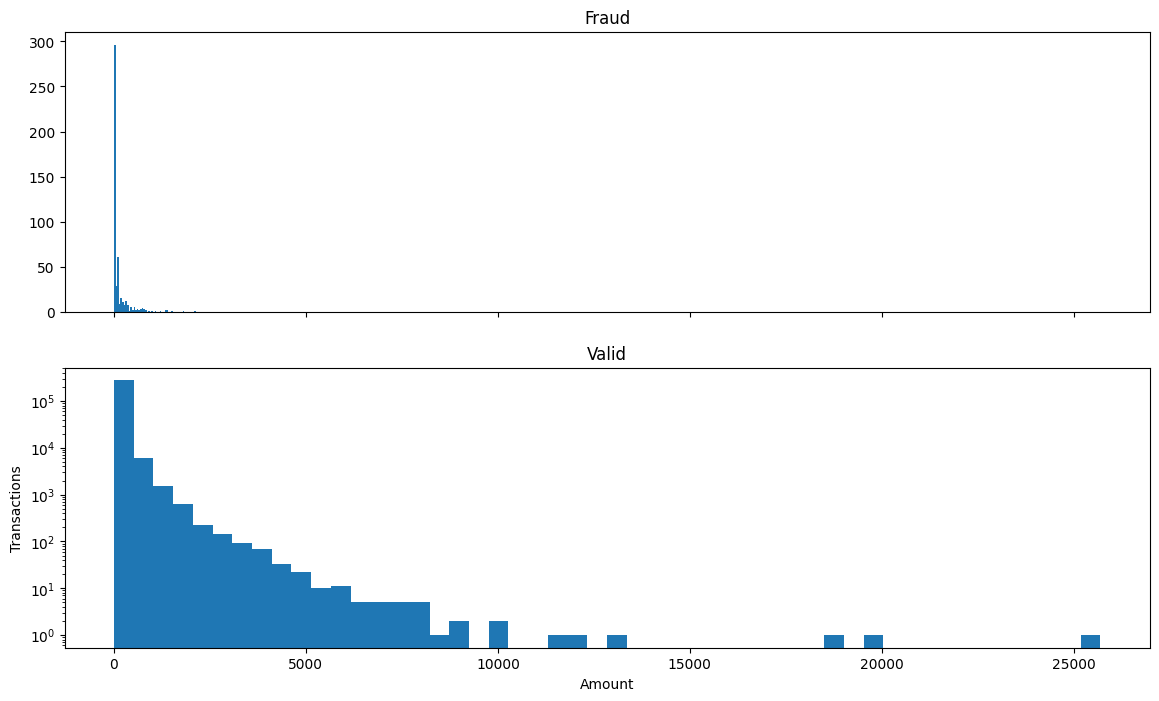

In [6]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Valid')
plt.xlabel('Amount')
plt.ylabel('Transactions')
plt.yscale('log')
plt.show()

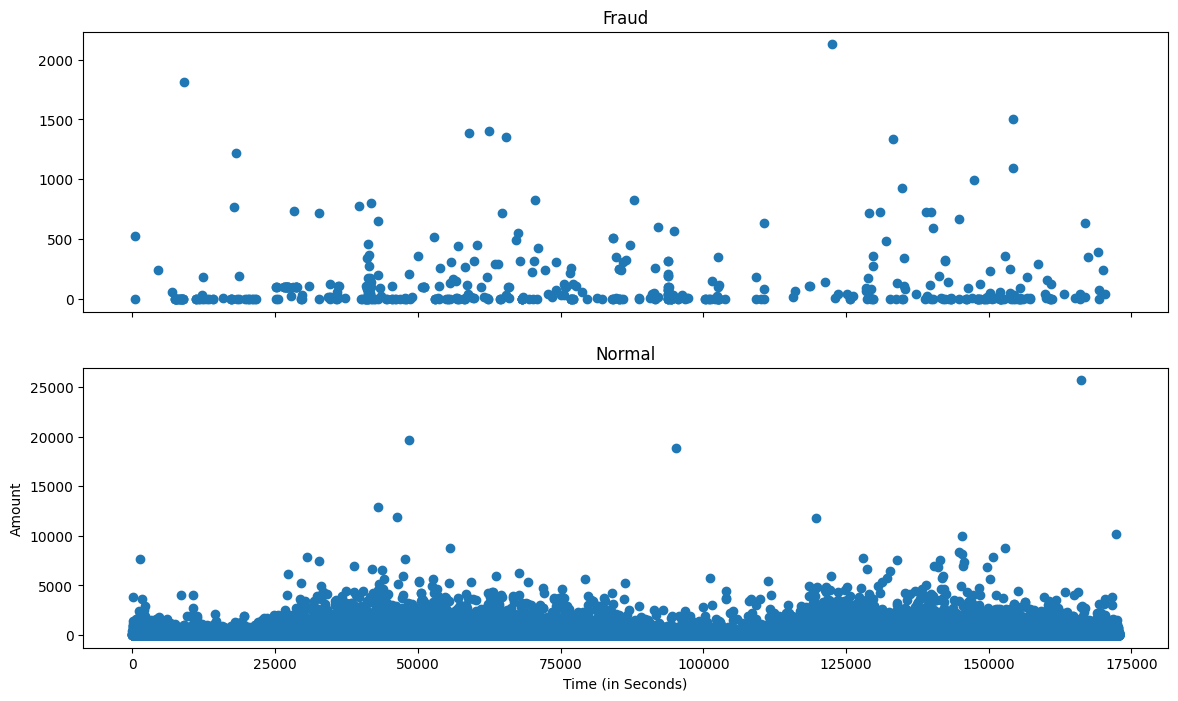

In [7]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [8]:
Fraud = data[data['Class']==1]
Valid = data[data['Class']==0]
outlier_fraction = len(Fraud)/float(len(Valid))
print("Fraud Cases : {}".format(len(Fraud)))
print("Valid Cases : {}".format(len(Valid)))
print(outlier_fraction)

Fraud Cases : 492
Valid Cases : 284315
0.0017304750013189597


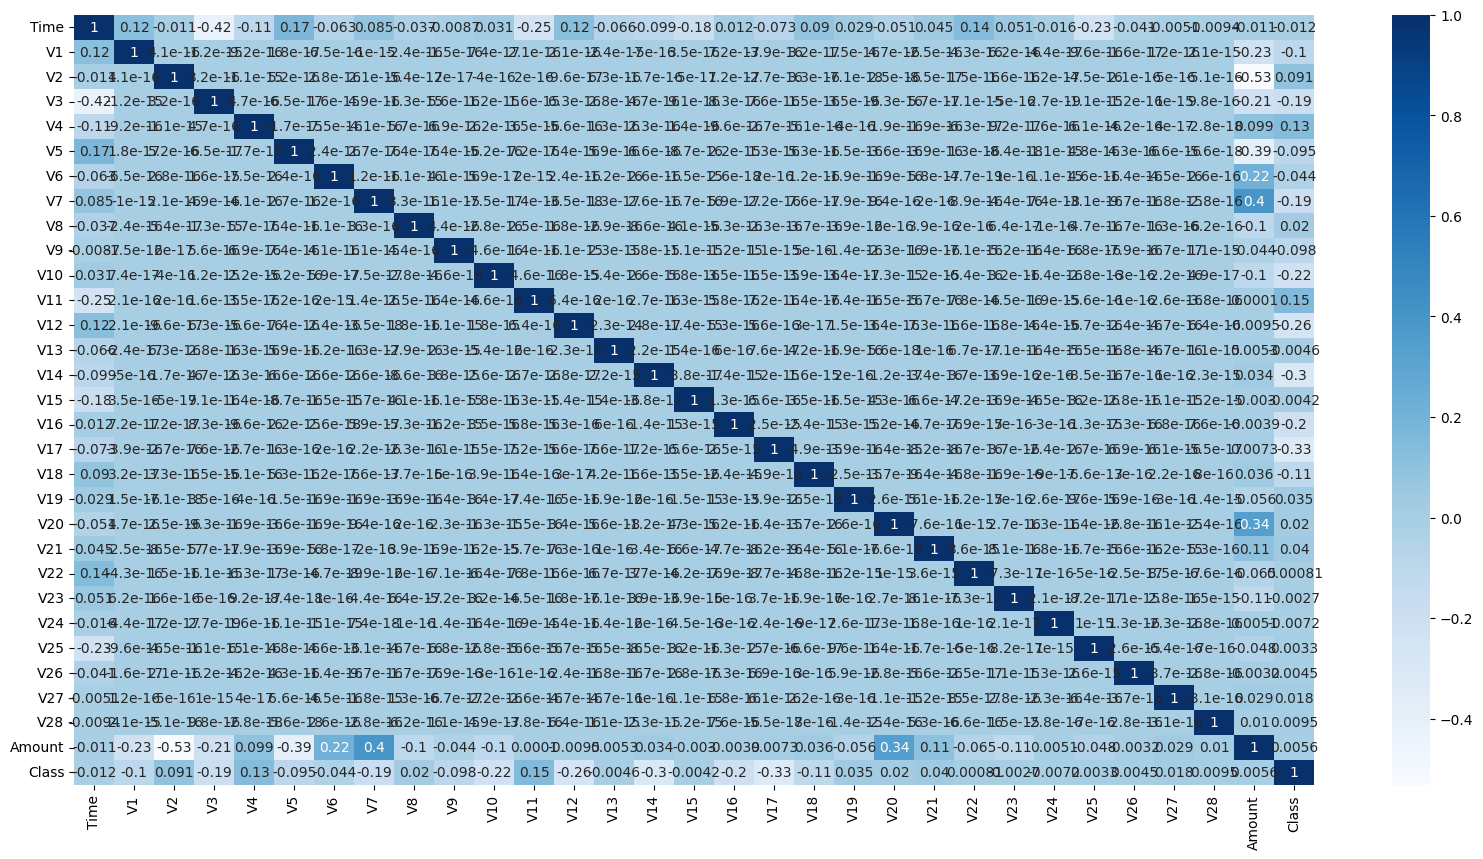

In [9]:
import seaborn as sns
cor1 = data.corr()
features = cor1.index
plt.figure(figsize=(20,10))
g=sns.heatmap(data[features].corr(),annot=True,cmap="Blues")

In [10]:
columns = data.columns.tolist()
columns = [c for c in columns if c not in ["Class"]]
target = "Class"
state = np.random.RandomState(42)
X = data[columns]
Y = data[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
print(X.shape)
print(Y.shape)

(284807, 30)
(284807,)


# Model Prediction

In [11]:
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction)
   
}

In [12]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 675
Accuracy Score :
0.9976299739823811
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.31      0.32      0.31       492

    accuracy                           1.00    284807
   macro avg       0.66      0.66      0.66    284807
weighted avg       1.00      1.00      1.00    284807

Local Outlier Factor: 935
Accuracy Score :
0.9967170750718908
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.05      0.05      0.05       492

    accuracy                           1.00    284807
   macro avg       0.52      0.52      0.52    284807
weighted avg       1.00      1.00      1.00    284807



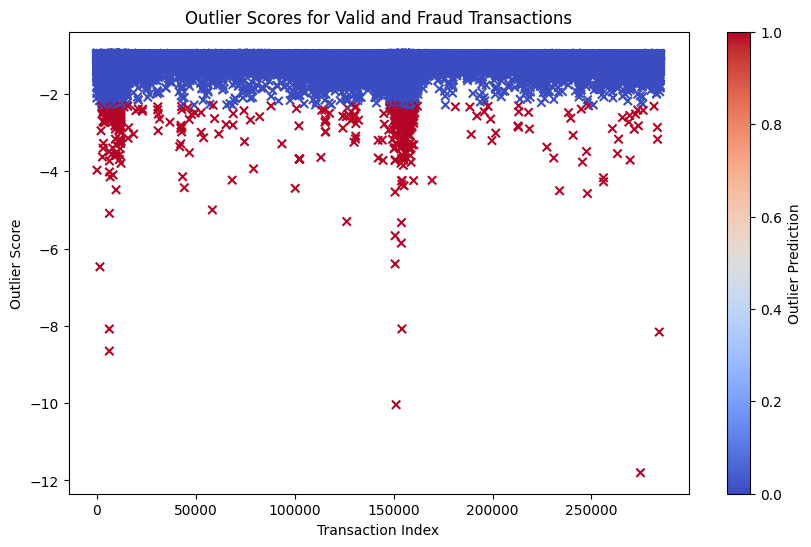

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(scores_prediction)), scores_prediction, c=y_pred, cmap='coolwarm', marker='x')
plt.colorbar(label='Outlier Prediction')
plt.title('Outlier Scores for Valid and Fraud Transactions')
plt.xlabel('Transaction Index')
plt.ylabel('Outlier Score')
plt.show()